In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

# Nornet edge Comparison

## Speedtest data

In [2]:
df = pd.read_csv('../datasets/nornet/speedtest_2021_share.csv')

# add locations to df
df = pd.merge(df, pd.read_csv('../datasets/nornet/node_locations_2021_share.csv'), left_on='node_id', right_on='node_id')

df.ts = pd.to_datetime(df.ts)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36303 entries, 0 to 36302
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ts                 36303 non-null  datetime64[ns]
 1   node_id            36303 non-null  int64         
 2   network_id         36303 non-null  int64         
 3   speedtest_ul_mbps  36303 non-null  float64       
 4   speedtest_dl_mbps  36303 non-null  float64       
 5   rat_before         1074 non-null   float64       
 6   rat_after          1074 non-null   float64       
 7   municipality       36303 non-null  object        
 8   zip                36303 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 2.8+ MB


In [3]:
# map network id to name
def map_net_id(row):
    if row == 1:
        return 'Telenor'
    elif row == 2:
        return 'Telia'
    elif row == 18:
        return 'Ice'
    else:
        return 'Unknown'

df['network'] = df['network_id'].copy().apply( lambda row: map_net_id(row))


# remove all download speeds above 450 Mbit/s
df = df[df['speedtest_dl_mbps']<=450]
df = df[df['speedtest_ul_mbps']<=100]

# will look at trøndelag data first

df_tron = df[df['municipality']== 'Trondheim']
df_osl= df[df['municipality']== 'Oslo']

df_combined = df[(df['municipality']== 'Trondheim')|(df['municipality']== 'Oslo')]

# setting datetime index 
df_tron.index = df_tron.ts
df_combined.index = df_combined.ts
df_tron= df_tron.drop(columns='ts')
df_combined= df_combined.drop(columns='ts')


# Unique nodes
print('Total nodes: ' + str( df_combined['node_id'].nunique()))
print('Total nodes Trd: ' + str( df_tron['node_id'].nunique()))
print('Total nodes Oslo: ' + str( df_osl['node_id'].nunique()))
print('Conncected RAN:\n' + str( df_combined.groupby(["network"])['node_id'].nunique()))


Total nodes: 32
Total nodes Trd: 7
Total nodes Oslo: 25
Conncected RAN:
network
Ice         2
Telenor    30
Telia      27
Name: node_id, dtype: int64


<AxesSubplot:xlabel='ts'>

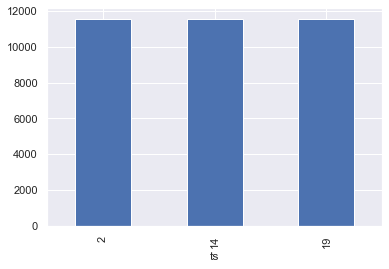

In [4]:
# What hour of the day is speedtes run. 
df_combined['node_id'].groupby(df_combined.index.hour).count().plot(kind='bar')

In [5]:
area1 = ['Trondheim', 'Melhus', 'Skaun']

mob_data = pd.read_csv("../datasets/joined_mobdata.zip", compression='zip')
mob_data.tid = pd.to_datetime(mob_data.tid)
mob_data.index = mob_data.tid
mob_data = mob_data.drop('tid', axis=1)
mob_data = mob_data[mob_data['teknologi'] == '4G']

#remove down speeds over 450 Mbit/s 
mob_data = mob_data[mob_data.hastighet_ned < 450]
mob_data = mob_data[mob_data.hastighet_opp < 100]

mob_data = mob_data.loc['2021']
mob_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20651 entries, 2021-01-01 00:02:00 to 2021-12-31 23:31:00
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             20651 non-null  int64  
 1   hastighet_ned          20651 non-null  float64
 2   hastighet_opp          20651 non-null  float64
 3   lengdegrad             20651 non-null  float64
 4   breddegrad             20651 non-null  float64
 5   klient_type            20651 non-null  object 
 6   teknologi              20651 non-null  object 
 7   ip_as_name             20630 non-null  object 
 8   nettverkstype          20651 non-null  int64  
 9   landkode               20631 non-null  object 
 10  land_geoip             20651 non-null  object 
 11  tilbyder               8106 non-null   object 
 12  enhets_platform        20651 non-null  object 
 13  enhets_os              20651 non-null  object 
 14  enhet              

In [6]:
daily_mean2 = mob_data[['hastighet_ned', 'hastighet_opp']].resample('D').mean()
daily_median2 = mob_data[['hastighet_ned', 'hastighet_opp']].resample('D').median()
count =  mob_data['hastighet_ned'].resample('D').count()
daily_metrics2= pd.DataFrame(pd.concat([daily_mean2, daily_median2], axis=1))
daily_metrics2.columns = ['mean_ul', 'mean_dl', 'median_ul', 'median_dl']
daily_median2 = daily_metrics2.dropna()

<AxesSubplot:xlabel='tid'>

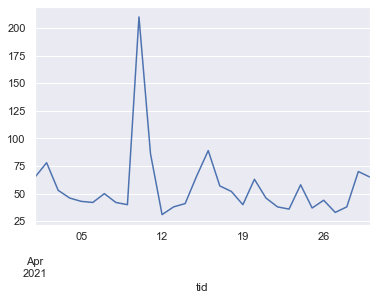

In [7]:
count.loc['2021-04'].plot()

In [8]:
daily_metrics2.head(15)

,mean_ul,mean_dl,median_ul,median_dl
tid,,,,
2021-01-01,45.553807,13.651526,25.6580,8.1890
2021-01-02,57.779057,9.520800,60.9490,8.1230
2021-01-03,66.125447,12.538702,30.9540,5.1730
2021-01-04,31.664059,8.147265,8.6145,2.4770
2021-01-05,59.919500,11.815839,26.8685,4.5150
2021-01-06,98.079942,13.552019,87.1060,9.4935
2021-01-07,61.471984,12.213344,56.2535,7.7915
2021-01-08,51.973531,11.263813,27.0180,7.3490
2021-01-09,55.081339,13.689500,29.8350,7.2155


In [9]:
mob_data['navn'].loc['2021-04-10'].value_counts()

Oslo            21
Hitra           17
Trondheim       10
Hvaler           9
Bærum            6
                ..
Voss             1
Vestre Toten     1
Hurdal           1
Stjørdal         1
Bardu            1
Name: navn, Length: 86, dtype: int64

In [10]:
mob_data['sim_operator_name'].value_counts().head(25)

Telenor        8692
Telia N        6337
N Telenor      1190
Ice Norway      772
ice+            703
One Call        341
Talkmore        325
Chilimobil      324
OneCall         321
ice             272
ice pluss       233
Fjordkraft      177
TELENOR         166
Chess            83
Vipps            81
Carrier          54
ice - Telia      50
Nortel           49
Happybytes       46
NetCom           43
SAGA MOBIL       39
Unifon           36
Dipper           32
MyCall           28
Telipol          24
Name: sim_operator_name, dtype: int64

In [11]:
telenor_users = ['Telenor','N Telenor', 'TELENOR', 'Talkmore', 'Fjordkraft', 'Vipps', 'Happybytes']
telia_users = ['Telia N','One Call', 'OneCall', 'Chilimobil', 'Chess', 'NetCom']
ice_users =['Ice Norway', 'ice+', 'ice pluss', 'ice.net', 'ice']

# get network based on row.
def get_network(row):
    if row in telenor_users:
        return 'Telenor'
    elif row in telia_users:
        return 'Telia'
    elif row in ice_users:
        return 'Ice'
    else:
        return np.nan
    
# map to new collumn
mob_data['network'] = mob_data['sim_operator_name'].copy().apply( lambda row: get_network(row))

mob_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20651 entries, 2021-01-01 00:02:00 to 2021-12-31 23:31:00
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             20651 non-null  int64  
 1   hastighet_ned          20651 non-null  float64
 2   hastighet_opp          20651 non-null  float64
 3   lengdegrad             20651 non-null  float64
 4   breddegrad             20651 non-null  float64
 5   klient_type            20651 non-null  object 
 6   teknologi              20651 non-null  object 
 7   ip_as_name             20630 non-null  object 
 8   nettverkstype          20651 non-null  int64  
 9   landkode               20631 non-null  object 
 10  land_geoip             20651 non-null  object 
 11  tilbyder               8106 non-null   object 
 12  enhets_platform        20651 non-null  object 
 13  enhets_os              20651 non-null  object 
 14  enhet              

In [12]:
mob_data[mob_data['navn'] == 'Trondheim']['network'].value_counts()

Telia      273
Telenor    181
Ice         38
Name: network, dtype: int64

In [13]:
mob_data[mob_data['navn'] == 'Oslo']['network'].value_counts()

Telia      460
Telenor    456
Ice        148
Name: network, dtype: int64

## Looking at all data from Trd and Oslo combined

In [14]:
mob_trd_osl = mob_data[mob_data['navn'].isin(['Oslo', 'Trondheim'])].reset_index()
order=['Telenor', 'Telia', 'Ice']

### compare all nodes with all 4G data for trd and oslo

<AxesSubplot:xlabel='speedtest_dl_mbps', ylabel='Proportion'>

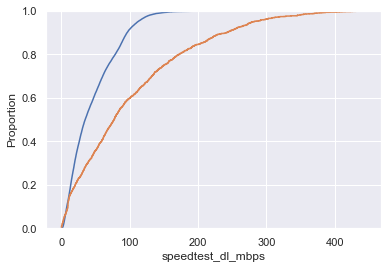

In [15]:
#testing different plots
fix, ax = plt.subplots()
sns.ecdfplot(df_combined.reset_index(), x="speedtest_dl_mbps", ax=ax )
sns.ecdfplot(data=mob_trd_osl, x='hastighet_ned', ax=ax )

<AxesSubplot:xlabel='speedtest_dl_mbps', ylabel='Count'>

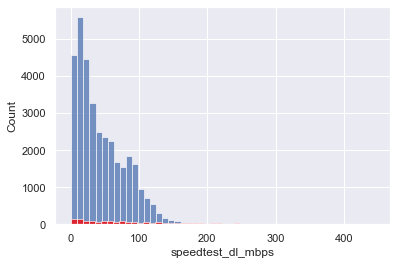

In [16]:
fix, ax = plt.subplots()

sns.histplot(data=df_combined.reset_index(), x="speedtest_dl_mbps", ax=ax , bins=50)
sns.histplot(data=mob_trd_osl, x='hastighet_ned', ax=ax, bins=50, color='red' )


/Users/jesper/master/master_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jesper/master/master_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


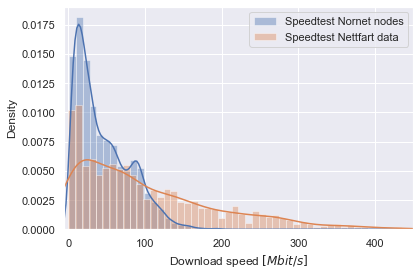

In [17]:
fix, ax = plt.subplots()
sns.distplot(df_combined["speedtest_dl_mbps"], ax=ax , bins=50, label="Speedtest Nornet nodes")
sns.distplot(mob_trd_osl['hastighet_ned'], ax=ax, bins=50, label="Speedtest Nettfart data" )

ax.set_xlabel("Download speed $[Mbit/s]$")
ax.set_xlim(-5, 450)
plt.legend()
plt.tight_layout()
plt.savefig('figs/data_comp/nornet_comp_density_dl')
plt.show()

/Users/jesper/master/master_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jesper/master/master_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


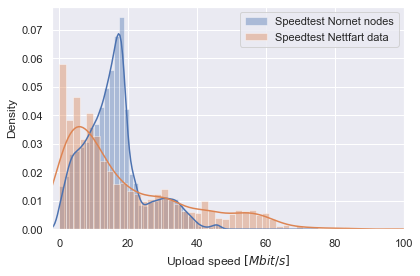

In [18]:
fix, ax = plt.subplots()
sns.distplot(df_combined["speedtest_ul_mbps"], ax=ax , bins=50, label="Speedtest Nornet nodes")
sns.distplot(mob_trd_osl['hastighet_opp'], ax=ax, bins=50, label="Speedtest Nettfart data" )

ax.set_xlabel("Upload speed $[Mbit/s]$")
ax.set_xlim(-2, 100)

plt.legend()
plt.tight_layout()
plt.savefig('figs/data_comp/nornet_comp_density_ul')
plt.show()

## Development

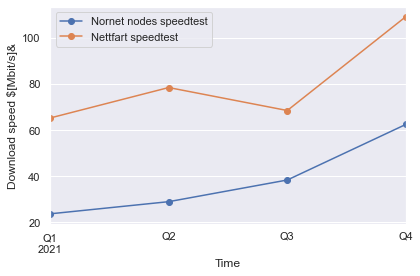

In [19]:
metrics_nor = df_combined[['speedtest_ul_mbps', 'speedtest_dl_mbps']]
Q_mean_nor = metrics_nor.resample('Q').mean()
Q_median_nor = metrics_nor.resample('Q', label='right').median()


metrics_net = mob_trd_osl[['hastighet_opp', 'hastighet_ned', 'tid']]
Q_mean_net = metrics_net.resample('Q', on='tid').mean()
Q_median_net = metrics_net.resample('Q', on='tid', label='right').median()

fix, ax = plt.subplots()
Q_median_nor['speedtest_dl_mbps'].plot(kind='line',ax=ax, label='Nornet nodes speedtest', style='-o')
Q_median_net['hastighet_ned'].plot(kind='line', ax=ax, label='Nettfart speedtest', style='-o')
plt.ylabel('Download speed $[Mbit/s]&')
plt.xlabel('Time')
plt.tight_layout()
plt.legend()
#plt.savefig('figs/data_comp/dev_dl_nn_netf')
plt.show()

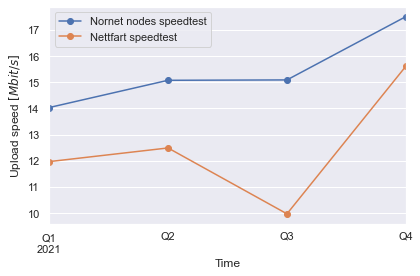

In [20]:
fix, ax = plt.subplots()
Q_median_nor['speedtest_ul_mbps'].plot(ax=ax, label='Nornet nodes speedtest', style='-o')
Q_median_net['hastighet_opp'].plot(ax=ax, label='Nettfart speedtest', style='-o')
ax.set_ylabel('Upload speed $[Mbit/s]$')
plt.xlabel('Time')
plt.tight_layout()
plt.legend()
#plt.savefig('figs/data_comp/dev_ul_nn_netf')

plt.show()

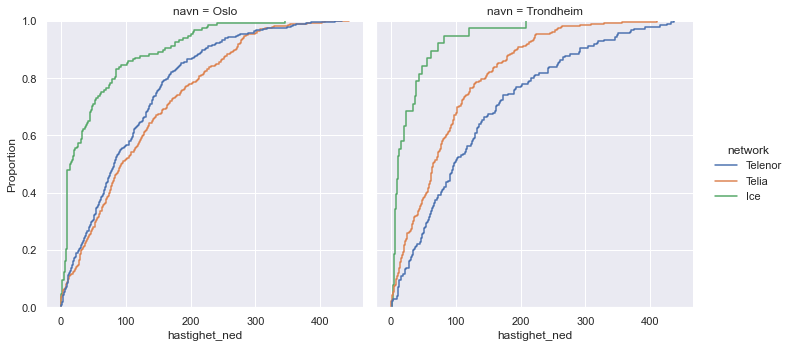

In [21]:
sns.displot(mob_trd_osl ,kind='ecdf', x='hastighet_ned', hue='network', col='navn', hue_order=order)

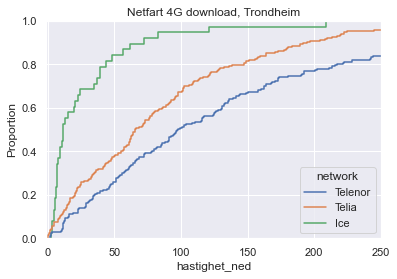

In [22]:
fig, ax = plt.subplots()
sns.ecdfplot(mob_trd_osl[mob_trd_osl.navn == 'Trondheim'], x='hastighet_ned', hue='network' , ax=ax, hue_order=order)
ax.set_title("Netfart 4G download, Trondheim")
ax.set_xlim(-1, 250)
plt.show()


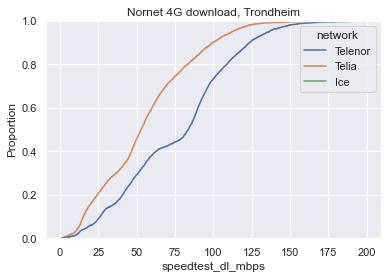

In [23]:
fig, ax = plt.subplots()

sns.ecdfplot(df_tron.reset_index(), x='speedtest_dl_mbps', hue='network' , ax=ax, hue_order=order)
ax.set_title("Nornet 4G download, Trondheim")
plt.show()



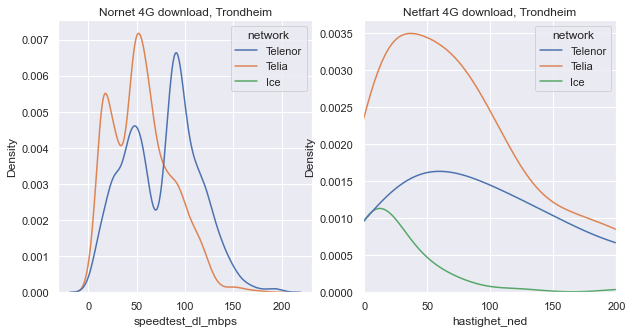

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

sns.kdeplot(data=df_tron.reset_index(), x='speedtest_dl_mbps',hue='network', ax=ax[0], hue_order=order)
ax[0].set_title("Nornet 4G download, Trondheim")
sns.kdeplot(data=mob_trd_osl[mob_trd_osl.navn == 'Trondheim'], x='hastighet_ned', hue='network' , ax=ax[1], hue_order=order)
ax[1].set_title("Netfart 4G download, Trondheim")
ax[1].set_xlim(-1, 200)
plt.show()

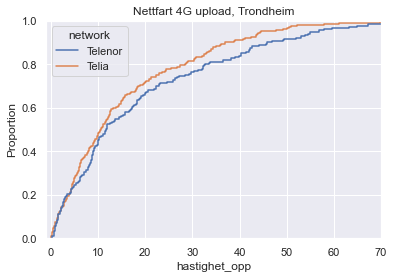

In [25]:
fig, ax = plt.subplots()
sns.ecdfplot(mob_trd_osl[mob_trd_osl.navn == 'Trondheim'], x='hastighet_opp', hue='network' , ax=ax, hue_order=['Telenor', 'Telia'])
ax.set_title("Nettfart 4G upload, Trondheim")
ax.set_xlim(-1,70)
plt.show()


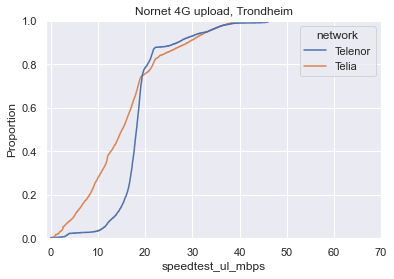

In [26]:
fig, ax = plt.subplots()
sns.ecdfplot(df_tron.reset_index(), x='speedtest_ul_mbps', hue='network' , ax=ax, hue_order=['Telenor', 'Telia'])
ax.set_title("Nornet 4G upload, Trondheim")
ax.set_xlim(-1, 70)
plt.show()

Diskisjons punkter
- distribution shapes (what does it tell of when people test?)

### Oslo ecdfs

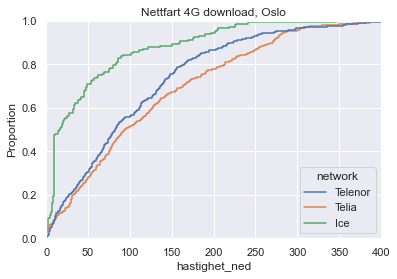

In [27]:
order=['Telenor', 'Telia', 'Ice']
fig, ax = plt.subplots()
sns.ecdfplot(mob_trd_osl[mob_trd_osl.navn == 'Oslo'], x='hastighet_ned', hue='network' , ax=ax, hue_order=order)
ax.set_title("Nettfart 4G download, Oslo")
ax.set_xlim(0,400)
plt.show()


Some download speeds above the therteical capasities of the mobile network (4G ++). Might be due to Wifi handover during the measuremnt procedure.  

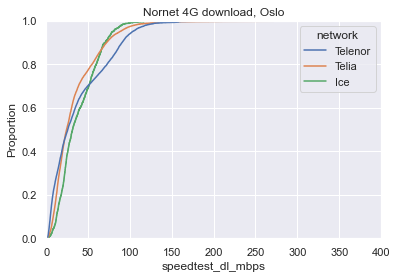

In [28]:
fig, ax = plt.subplots()

sns.ecdfplot(df_osl.reset_index(), x='speedtest_dl_mbps', hue='network' , ax=ax, hue_order=order)
ax.set_title("Nornet 4G download, Oslo")
ax.set_xlim(0 , 400)
plt.show()

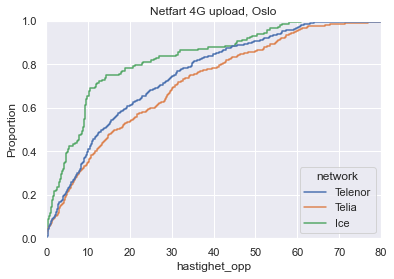

In [29]:
fig, ax = plt.subplots()
sns.ecdfplot(mob_trd_osl[mob_trd_osl.navn == 'Oslo'], x='hastighet_opp', hue='network' , ax=ax, hue_order=order)
ax.set_title("Netfart 4G upload, Oslo")
ax.set_xlim(0,80)
plt.show()

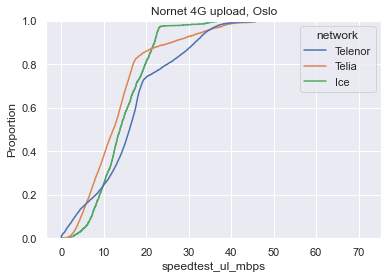

In [30]:
fig, ax = plt.subplots()
sns.ecdfplot(df_osl.reset_index(), x='speedtest_ul_mbps', hue='network' , ax=ax, hue_order=order)
ax.set_title("Nornet 4G upload, Oslo")
plt.show()

## Downtime distributions

Importing connectivity data

In [31]:
df = pd.read_csv('../datasets/nornet/connectivity_2021_share.csv')

df = pd.merge(df, pd.read_csv('../datasets/nornet/node_locations_2021_share.csv'), left_on='node_id', right_on='node_id')

df.timestamp = pd.to_datetime(df.timestamp)

down_df = df[df['state_during_event']== 'DOWN']

down_df

,node_id,network_id,timestamp,time_duration,state_during_event,municipality,zip
0,312,1,2021-02-04 01:09:09.404009984,19.228928,DOWN,Trondheim,7070
2,312,1,2021-02-04 01:12:49.374070016,10.613747,DOWN,Trondheim,7070
5,312,1,2021-04-25 23:09:18.262779904,135.078239,DOWN,Trondheim,7070
7,312,1,2021-04-28 03:17:36.728570112,10.409001,DOWN,Trondheim,7070
9,312,1,2021-05-03 17:38:03.620549888,44.767314,DOWN,Trondheim,7070
...,...,...,...,...,...,...,...
4242,1075,2,2021-07-06 00:41:48.000000000,1.000000,DOWN,Oslo,784
4249,1075,2,2021-07-23 14:26:53.000000000,6.000000,DOWN,Oslo,784
4250,1075,2,2021-07-23 14:29:40.000000000,5.000000,DOWN,Oslo,784
4253,1075,2,2021-08-01 15:03:43.000000000,11.000000,DOWN,Oslo,784


In [32]:
down_df.sort_values(by='time_duration', ascending=False).head(10)

,node_id,network_id,timestamp,time_duration,state_during_event,municipality,zip
2708,1064,2,2021-12-08 05:34:46.000000000,435.000000,DOWN,Trondheim,7045
2686,1064,2,2021-12-07 22:08:36.000000000,391.000000,DOWN,Trondheim,7045
1956,1063,1,2021-03-08 00:03:38.000000000,206.000000,DOWN,Oslo,383
435,855,1,2021-04-25 23:09:56.000000000,183.000000,DOWN,Oslo,1266
1897,1026,2,2021-06-02 00:08:14.000000000,145.000000,DOWN,Oslo,259
636,856,1,2021-05-02 23:59:50.000000000,144.000000,DOWN,Oslo,1185
1969,1063,1,2021-04-25 23:03:43.000000000,136.000000,DOWN,Oslo,383
5,312,1,2021-04-25 23:09:18.262779904,135.078239,DOWN,Trondheim,7070
3310,1068,2,2021-08-24 22:53:00.000000000,135.000000,DOWN,Trondheim,7054
3992,1075,1,2021-05-03 00:00:16.000000000,122.000000,DOWN,Oslo,784


## Sum of downtime in both municipalities

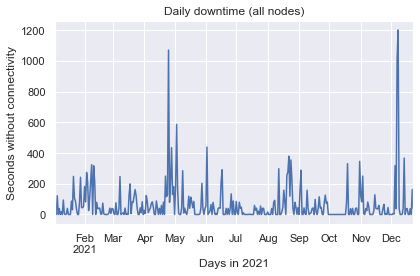

In [33]:
# sum down time for nodes each day


day_down = down_df[down_df.municipality.isin(['Oslo', 'Trondheim'])][['time_duration', 'timestamp']].resample('D', on='timestamp').sum()
day_down['tot_down_time'] = day_down['time_duration']
day_down = day_down.drop('time_duration', axis=1)
day_down['tot_down_time'].plot(title='Daily downtime (all nodes)')
plt.ylabel("Seconds without connectivity")
plt.xlabel("Days in 2021")
plt.tight_layout()
#plt.savefig("figs/data_comp/daily_downtime")

In [34]:

#breach in connection in number of unique nodes that day.  
day_group = down_df[down_df.municipality.isin(['Trondheim', 'Oslo'])].groupby(down_df.timestamp.dt.date)


# total registrerd down events 
day_down['tot_down_events'] = day_group['node_id'].count()
day_down['unique_down_nodes'] = day_group['node_id'].nunique(dropna=False)
day_down = day_down.fillna(0)
day_down.sort_values(by='unique_down_nodes', ascending= False).drop(['tot_down_events', 'tot_down_time'], axis=1).head(10)

,unique_down_nodes
timestamp,
2021-04-28,16.0
2021-01-28,13.0
2021-04-25,10.0
2021-11-18,9.0
2021-05-03,8.0
2021-11-19,8.0
2021-02-06,8.0
2021-06-02,8.0
2021-01-19,7.0


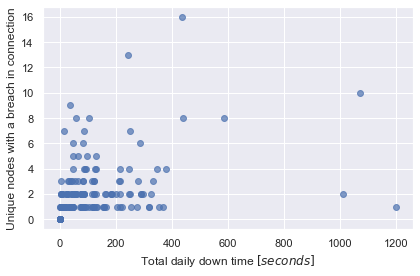

In [35]:
plt.scatter(day_down['tot_down_time'], day_down['unique_down_nodes'], alpha=0.7)
plt.xlabel('Total daily down time $[seconds]$ ')
plt.ylabel('Unique nodes with a breach in connection')
plt.tight_layout()
plt.savefig('figs/data_comp/downtime_v_unique_breaches')
plt.show()


In [36]:
#count number of nettfart measurments
day_down['nettfart_count']= mob_trd_osl.resample('D', on='tid')['hastighet_ned'].count()
#day_down['nettfart_median_down']= mob_trd_osl.resample('D', on='tid')['hastighet_ned'].median()
#day_down['nettfart_median_up']= mob_trd_osl.resample('D', on='tid')['hastighet_opp'].median()
#day_down['nettfart_media_latency']= mob_trd_osl.resample('D', on='tid')['ping_median'].median()



In [37]:
corr_matrix = day_down.corr()

# Fill diagonal and upper half with NaNs
#mask = np.zeros_like(corr_matrix, dtype=bool)
#mask[np.triu_indices_from(mask)] = True
#corr_matrix[mask] = np.nan
(corr_matrix
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,tot_down_time,tot_down_events,unique_down_nodes,nettfart_count
tot_down_time,1.00,0.78,0.48,-0.05
tot_down_events,0.78,1.00,0.77,-0.02
unique_down_nodes,0.48,0.77,1.00,-0.02
nettfart_count,-0.05,-0.02,-0.02,1.00


In [38]:
# averge daily measurments
day_down['nettfart_count'].sum()

1596

In [39]:
day_down['tot_down_time'].mean()

63.88035557706591

In [40]:
# sum down time for nodes each day

muni = 'Oslo'
day_down2 = down_df[down_df.municipality == muni][['time_duration', 'timestamp']].resample('D', on='timestamp').sum()

day_down2['telenor_down_time'] = down_df[
    (down_df.municipality == muni) & 
    (down_df.network_id== 1)][['time_duration', 'timestamp']].resample('D', on='timestamp').sum()
day_down2['telia_down_time'] = down_df[
    (down_df.municipality == muni) & 
    (down_df.network_id== 2)][['time_duration', 'timestamp']].resample('D', on='timestamp').sum()

<AxesSubplot:title={'center':'Daily downtime in Oslo'}, xlabel='timestamp'>

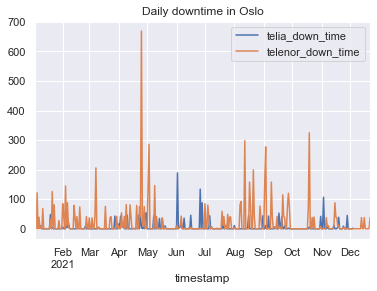

In [41]:
day_down2[['telia_down_time', 'telenor_down_time']].plot(title='Daily downtime in ' + muni)

In [42]:
trd_count = mob_trd_osl[['tid']].resample('D', on = 'tid').count()

<AxesSubplot:xlabel='tid'>

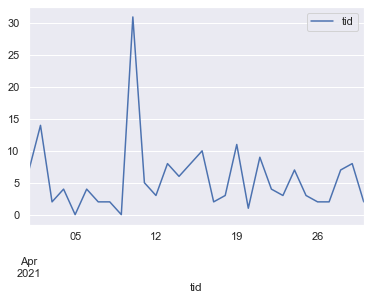

In [43]:
trd_count.loc['2021-04'].plot()

<AxesSubplot:xlabel='time_duration', ylabel='Count'>

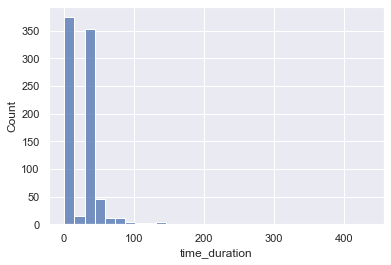

In [44]:
sns.histplot(down_df['time_duration'], bins=30)

In [45]:
down_df.sort_values(by='time_duration', ascending=False).head(10)

,node_id,network_id,timestamp,time_duration,state_during_event,municipality,zip
2708,1064,2,2021-12-08 05:34:46.000000000,435.000000,DOWN,Trondheim,7045
2686,1064,2,2021-12-07 22:08:36.000000000,391.000000,DOWN,Trondheim,7045
1956,1063,1,2021-03-08 00:03:38.000000000,206.000000,DOWN,Oslo,383
435,855,1,2021-04-25 23:09:56.000000000,183.000000,DOWN,Oslo,1266
1897,1026,2,2021-06-02 00:08:14.000000000,145.000000,DOWN,Oslo,259
636,856,1,2021-05-02 23:59:50.000000000,144.000000,DOWN,Oslo,1185
1969,1063,1,2021-04-25 23:03:43.000000000,136.000000,DOWN,Oslo,383
5,312,1,2021-04-25 23:09:18.262779904,135.078239,DOWN,Trondheim,7070
3310,1068,2,2021-08-24 22:53:00.000000000,135.000000,DOWN,Trondheim,7054
3992,1075,1,2021-05-03 00:00:16.000000000,122.000000,DOWN,Oslo,784


In [46]:
down_df['time_duration'].groupby(down_df['timestamp'].dt.date).count()

timestamp
2021-01-03    1
2021-01-05    3
2021-01-07    1
2021-01-09    2
2021-01-11    4
             ..
2021-12-17    1
2021-12-18    1
2021-12-20    1
2021-12-22    5
2021-12-23    1
Name: time_duration, Length: 223, dtype: int64